<a href="https://colab.research.google.com/github/KelseyWang2022/Evaluation-algorithm-of-bus-route/blob/main/random_forest(feature_importance%2BPOD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 992.1 kB/s eta 0:00:00


ROC AUC Score: 0.9414581070313317
              precision    recall  f1-score   support

           1       0.84      0.88      0.86      1242
           2       0.73      0.31      0.44        35
           3       0.72      0.53      0.61       315
           4       0.81      0.84      0.83      1295

    accuracy                           0.82      2887
   macro avg       0.78      0.64      0.68      2887
weighted avg       0.81      0.82      0.81      2887

#####################PartialDependenceDisplay#########################


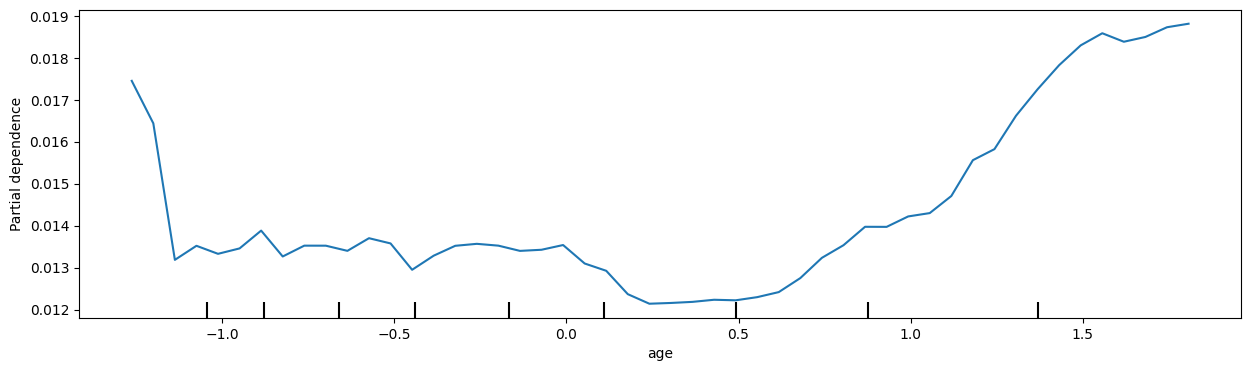

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report

# 加载数据
data = pd.read_csv(r'/content/merged_data_sample.csv')

# 定义目标变量和特征
categorical_features = ['lum', 'agg', 'int', 'atm', 'season', 'week', 'peak', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'senc', 'catv', 'obs', 'obsm', 'manv', 'motor', 'place', 'catu', 'sexe', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp']
numeric_features = ['nbv', 'vma', 'occutc', 'age']
target = 'grav'

X = data[categorical_features + numeric_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据预处理
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 使用中位数填充数值型特征的缺失值
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 使用众数填充分类特征的缺失值
    ('encoder', ce.TargetEncoder())  # 对分类特征进行目标编码
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 处理数据不均衡
smote = SMOTE(random_state=42)

# 随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 创建完整的处理流水线
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', rf)
])

# 模型训练
pipeline.fit(X_train, y_train)

# 模型预测
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

# 性能评估
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
print(f"ROC AUC Score: {roc_auc}")
report = classification_report(y_test, y_pred)
print(report)


print('#####################PartialDependenceDisplay#########################')
#在这里如果想要age显示原始的真实值的话，只能在初始的处理过程中忽略对age的预处理，该代码在age(without_processing)中进行
#print("Classes in classifier:", pipeline.named_steps['classifier'].classes_)因为POD只能显示某个特征对于某个类的影响

X_for_pdp = preprocessor.transform(X_train)  # This ensures all transformations are applied

features = ['age']  # Example feature
fig, ax = plt.subplots(figsize=(15, 4))# the size of figure

PartialDependenceDisplay.from_estimator(
    pipeline.named_steps['classifier'],  # Ensure this refers to your RandomForestClassifier
    X_for_pdp,  # Use preprocessed data
    features=features,  # Specify features to analyze
    feature_names=[f for f in numeric_features + categorical_features if f in X_train.columns],  # Ensure feature names match
    n_jobs=3,
    grid_resolution=50,
    ax=ax,
    target=2  # Specify the target class
)
plt.show()




In [6]:
import numpy as np

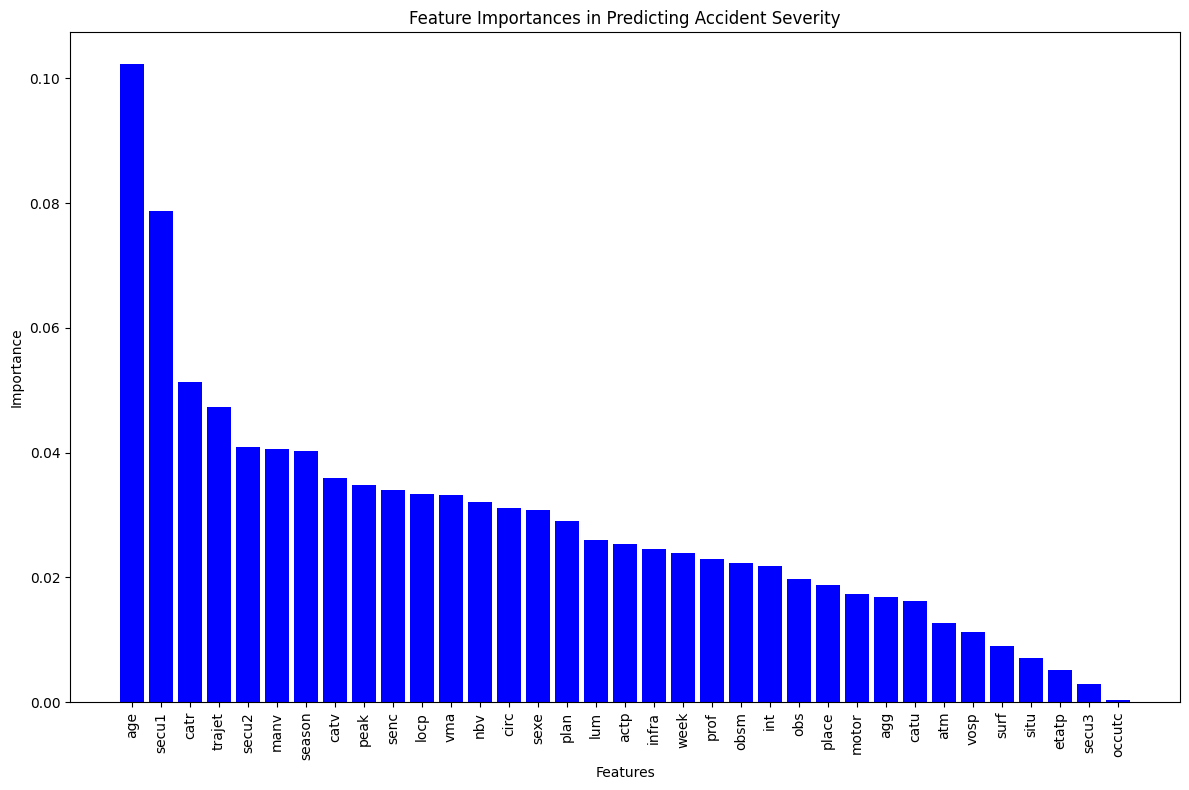

In [7]:
# 获取特征重要性
importances = pipeline.named_steps['classifier'].feature_importances_

# 获取特征名称
numeric_features = np.array(numeric_features)
categorical_features = np.array(categorical_features)
feature_names = np.concatenate([numeric_features, categorical_features])

# 对特征重要性进行排序
indices = np.argsort(importances)[::-1]

# 可视化特征重要性
plt.figure(figsize=(12, 8))
plt.title("Feature Importances in Predicting Accident Severity")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()